In [56]:
%pip install polars matplotlib numpy pandas seaborn scikit-learn pyarrow biopython ete3 PyQt5 statsmodels
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from Bio import SeqIO
from matplotlib import gridspec
import string
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_theme(context="paper")

Note: you may need to restart the kernel to use updated packages.


In [44]:
resistify_result = (
    pl.read_csv(
        "../results/resistify/final/results.tsv",
        separator="\t",
        has_header=True,
    )
    .with_columns(
        (pl.col("Sequence").str.replace(r".[t]?\d$", "").alias("gene")),
        (pl.col("Sequence").str.contains("solanum").alias("helixer")),
    )
    # Select largest transcript for each gene
    .group_by("gene")
    .agg(pl.all().sort_by("Length").last())
)

canonical_nlrs = (
    resistify_result
    .filter(pl.col("Classification") != "None")
    .select(pl.col("gene"))
    .unique()
)

lcpm = (
    pl.read_csv(
        "../results/tpm.tsv",
        separator="\t",
    )
    .with_columns((pl.col("tpm") + 1).log().alias("lcpm"))
    .select(pl.col("gene"), pl.col("condition"), pl.col("lcpm"))
)

homologs = (
    pl.read_csv(
        "../results/refplantnlr_diamond.tsv",
        separator="\t",
        has_header=False,
    )
    .select(
        sequence=pl.col("column_1"),
        homolog=pl.col("column_2"),
        identity=pl.col("column_3"),
    )
    .with_columns(
        pl.col("sequence").str.replace(r".t\d$", "").alias("gene")
    )
    .filter(pl.col("identity") > 85)
)

How many NLRs are there in the genome?

In [29]:
# Filter isoforms by selecting longest NLR for each gene
(
    resistify_result
    .group_by("gene")
    .agg(pl.all().sort_by("Length").last())
    .filter(pl.col("Classification") != "None")
    .count()
)

gene,Sequence,Length,Motifs,Domains,Classification,NBARC_motifs,MADA,MADAL,CJID,helixer
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
497,497,497,496,497,497,497,497,497,497,497


How many by classification?

In [30]:
# Filter isoforms by selecting longest NLR for each gene
(
    resistify_result
    .group_by("gene")
    .agg(pl.all().sort_by("Length").last())
    .filter(pl.col("Classification") != "None")
    .group_by("Classification")
    .count()
)

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_70651/2563212932.py:8: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()


Classification,count
str,u32
"""N""",71
"""RNL""",2
"""CN""",66
"""TNL""",45
"""NL""",61
"""CNL""",243
"""TN""",9


What is the proportion of MADA and CJID motifs?

In [31]:
# Filter isoforms by selecting longest NLR for each gene
(
    resistify_result
    .group_by("gene")
    .agg(pl.all().sort_by("Length").last())
    .filter(pl.col("Classification") != "None")
    .group_by("Classification")
    .agg(pl.sum("MADA"))
)

Classification,MADA
str,u32
"""RNL""",0
"""N""",0
"""CN""",12
"""NL""",1
"""TNL""",0
"""TN""",0
"""CNL""",30


# Expression analysis

Couple of things to check here.
* Are there differentially expressed NLRs across the different conditions?
* Are there broad changes in NLR expression between conditions?
* Are helixer predictions significantly differentially expressed?
  
Need to do some stats in between these


/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_70651/137198788.py:33: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_70651/137198788.py:43: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  resistify_result
/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_70651/137198788.py:54: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  resistify_result


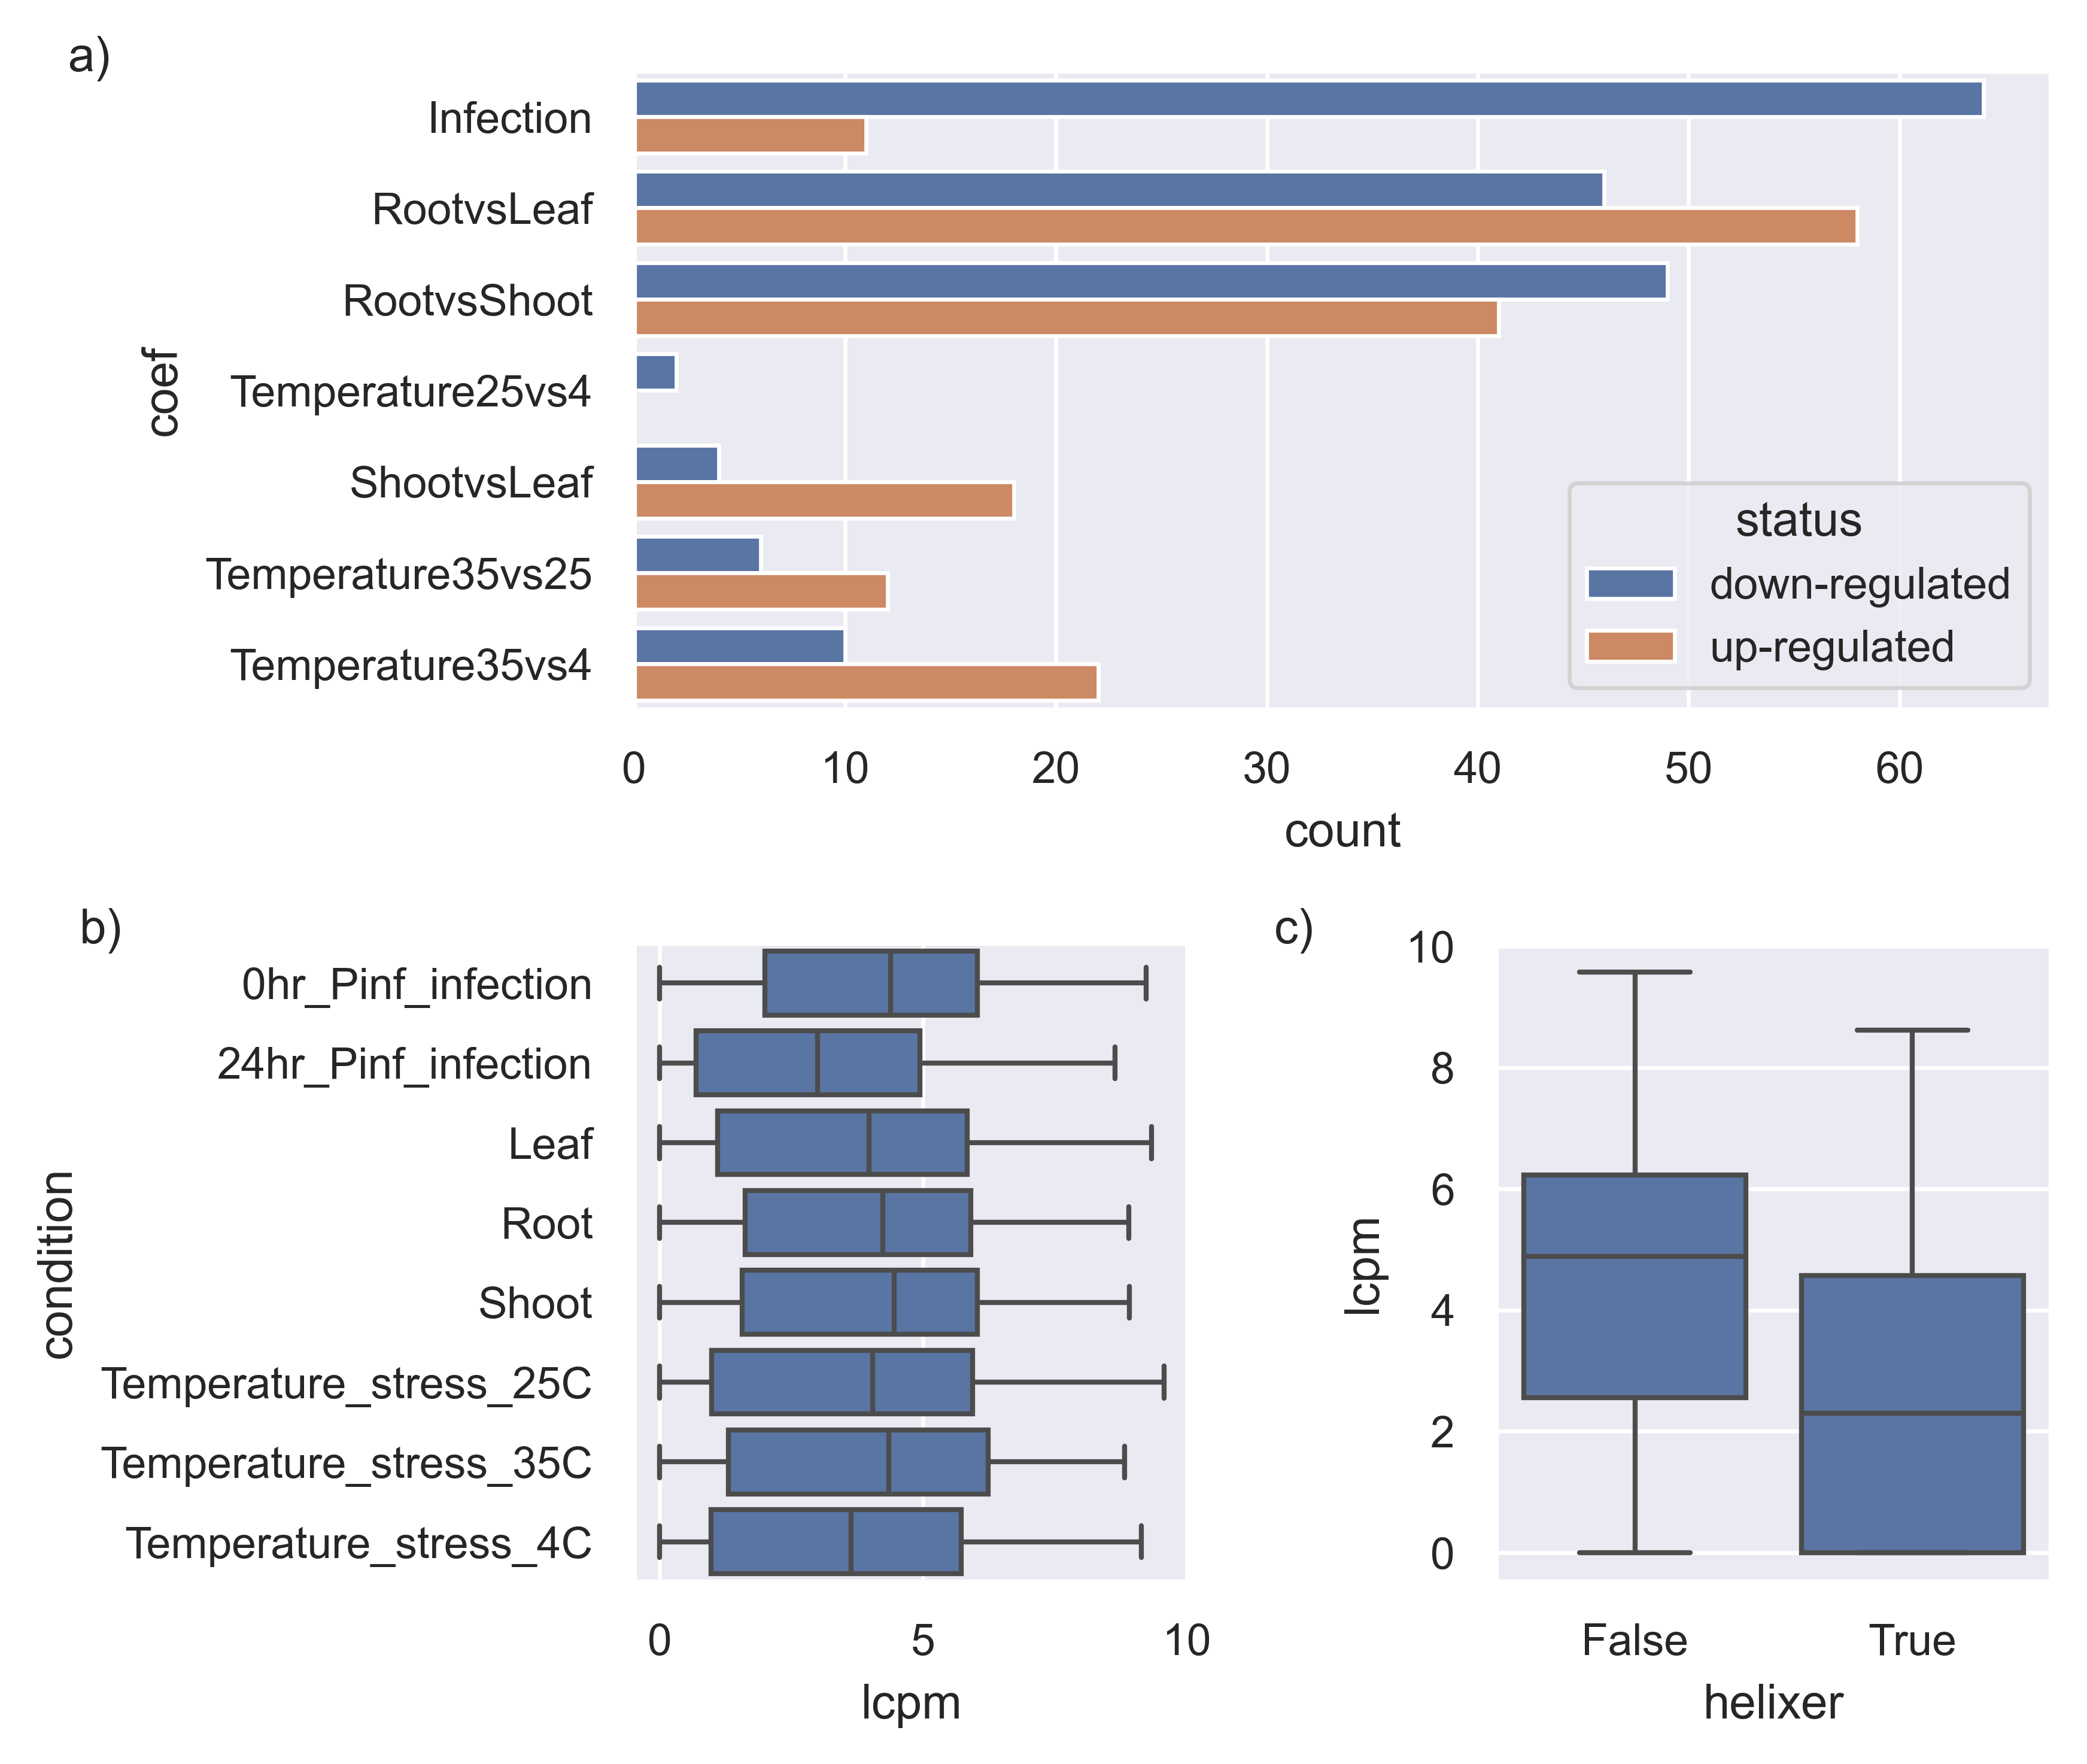

In [115]:
# Differentially expressed NLRs

differential_expression = (
    pl.read_csv(
        "../results/differential_expression.tsv",
        separator="\t",
        has_header=True,
    )
    .filter(pl.col("gene").is_in(canonical_nlrs))
)

fig = plt.figure(figsize=(5.9, 5), layout="tight", dpi=600)
gs = gridspec.GridSpec(2, 2)

axs = [fig.add_subplot(gs[0, :]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]

# Add in the subplot labels
label_x_coords = [-0.4, -1, -0.4]
label_y_coords = [1, 1, 1]
for n, ax in enumerate(axs):
    ax.text(
        label_x_coords[n],
        label_y_coords[n],
        f"{string.ascii_lowercase[n]})",
        transform=ax.transAxes,
    )

sns.barplot(
    (
        differential_expression
        .filter(pl.col("status") != "not significant")
        .group_by("coef", "status")
        .agg(pl.count().alias("count"))
    ),
    x="count",
    y="coef",
    hue="status",
    ax=axs[0],
)

sns.boxplot(
    (
        resistify_result
        .filter(pl.col("gene").is_in(canonical_nlrs))
        .join(lcpm, on="gene", how="left")
    ),
    y="condition",
    x="lcpm",
    ax=axs[1],
)

sns.boxplot(
    (
        resistify_result
        .filter(pl.col("gene").is_in(canonical_nlrs))
        .join(lcpm, on="gene", how="left")
    ),
    x="helixer",
    y="lcpm",
    ax=axs[2],
)

plt.savefig("../../pandoc-thesis/figures/nlr_expression.png")

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_70651/4243585467.py:4: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  resistify_result
/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_70651/4243585467.py:19: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  resistify_result


                            OLS Regression Results                            
Dep. Variable:                   lcpm   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     72.89
Date:                Sat, 15 Jun 2024   Prob (F-statistic):          2.61e-112
Time:                        13:09:26   Log-Likelihood:                -8899.7
No. Observations:                3920   AIC:                         1.782e+04
Df Residuals:                    3911   BIC:                         1.787e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_70651/4243585467.py:30: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  resistify_result


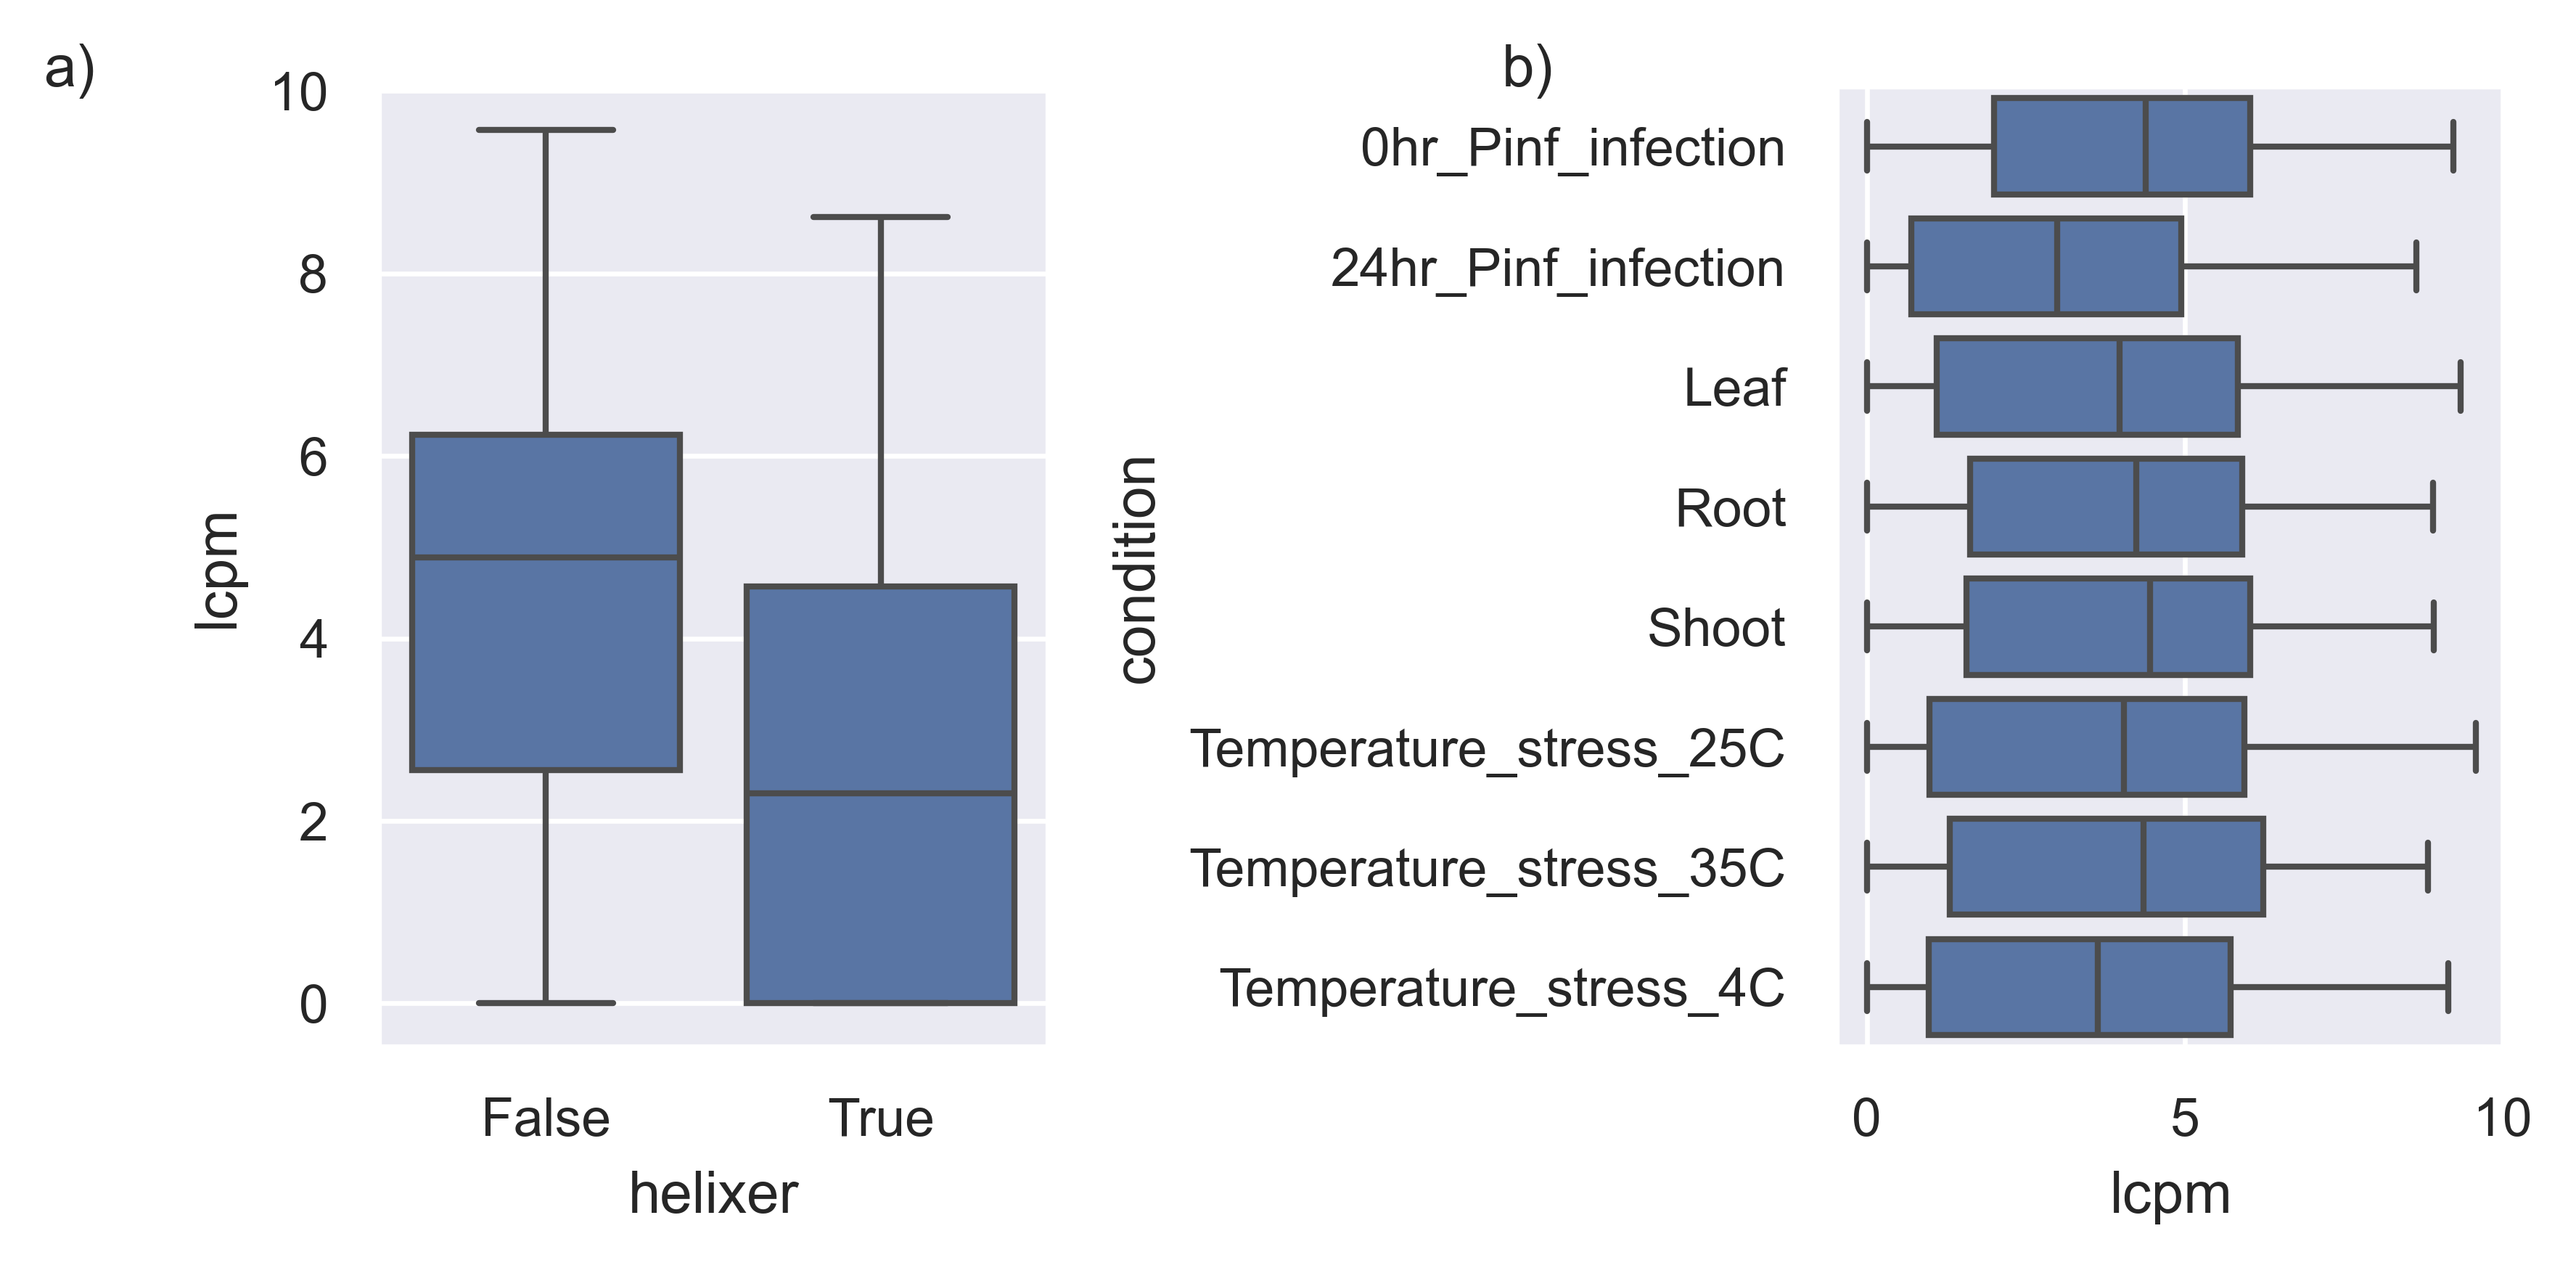

In [90]:
mod = smf.ols(
    formula="lcpm ~ condition + helixer",
    data = (
        resistify_result
        .filter(pl.col("gene").is_in(canonical_nlrs))
        .join(lcpm, on="gene", how="left")
    ).to_pandas(),
)
res = mod.fit()
print(res.summary())

Does expression vary by condition?

Transposable element overlaps

In [17]:
earlgrey_overlaps = (
    pl.read_csv(
        "../results/final_annotation/final_annotation.longest.earlgrey_overlap.bed",
        separator="\t",
        has_header=False,
    )
    .filter(pl.col("column_4").is_in(canonical_nlrs))
    .select(chrom=pl.col("column_10"), start=pl.col("column_11"), end=pl.col("column_12"))
    .join(
        (
            pl.read_csv(
                "../results/earlgrey/solanum_verrucosum_summaryFiles/solanum_verrucosum.filteredRepeats.gff",
                separator="\t",
                has_header=False,
            )
            .with_columns(
                pl.col("column_9").str.extract(r"ID=(.*?);").alias("ID"),
            )
            .select(chrom=pl.col("column_1"), start=pl.col("column_4"), end=pl.col("column_5"), ID=pl.col("ID"))
        ),
        on=["chrom", "start", "end"],
        how="full",
    )
)

earlgrey_overlaps

chrom,start,end,chrom_right,start_right,end_right,ID
str,i64,i64,str,i64,i64,str
null,null,null,"""chr08""",2,40,"""RND-2_FAMILY-121"""
null,null,null,"""chr08""",41,700,"""RND-5_FAMILY-11144"""
null,null,null,"""chr08""",701,972,"""RND-5_FAMILY-11144"""
null,null,null,"""chr08""",973,1177,"""RND-5_FAMILY-11144"""
null,null,null,"""chr08""",1178,1525,"""RND-5_FAMILY-11144"""
…,…,…,…,…,…,…
"""chr11""",1298685,1308896,null,null,null,null
"""chr04""",5867043,5867283,null,null,null,null
"""chr04""",3858667,3858997,null,null,null,null
